In [28]:
!curl https://files.grouplens.org/datasets/movielens/ml-latest-small.zip -o ml-latest-small.zip
#Loads the dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  955k  100  955k    0     0   375k      0  0:00:02  0:00:02 --:--:--  375k


In [29]:
import zipfile
with zipfile.ZipFile('ml-latest-small.zip', 'r') as zip_ref:
  zip_ref.extractall('data')

#Imports the dataset

In [30]:
# Optional, clears previous session
import tensorflow.keras.backend as K
K.clear_session()

In [53]:
import pymc as pm
print(pm.__version__)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sklearn
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
print(tf.__version__)
import seaborn

5.19.1
2.17.1


In [32]:
# Import data

ratings = pd.read_csv('data/ml-latest-small/ratings.csv')
movies = pd.read_csv('data/ml-latest-small/movies.csv')

In [33]:
# sample 10% randomly, random_state ensures reproducibility
ratings = ratings.sample(frac=0.1, random_state=42)  # 0.1 means 10% of the dataset
movies = movies.sample(frac=0.1, random_state=42)

In [34]:
print(ratings.head(3), '\n')
print(movies.head(3))

       userId  movieId  rating   timestamp
67037     432    77866     4.5  1335139641
42175     288      474     3.0   978465565
93850     599     4351     3.0  1498524542 

      movieId                                   title  \
6213    45635       Notorious Bettie Page, The (2005)   
1056     1373  Star Trek V: The Final Frontier (1989)   
4891     7325                  Starsky & Hutch (2004)   

                            genres  
6213                         Drama  
1056                 Action|Sci-Fi  
4891  Action|Comedy|Crime|Thriller  


In [35]:
print(ratings.describe())

             userId        movieId        rating     timestamp
count  10084.000000   10084.000000  10084.000000  1.008400e+04
mean     322.784907   19313.723721      3.492562  1.204749e+09
std      182.211773   35573.872889      1.050611  2.167179e+08
min        1.000000       1.000000      0.500000  8.281246e+08
25%      174.000000    1197.000000      3.000000  1.013367e+09
50%      318.000000    2985.000000      3.500000  1.182231e+09
75%      474.000000    7439.000000      4.000000  1.436393e+09
max      610.000000  193567.000000      5.000000  1.537632e+09


In [36]:
# Check for missing values
print(ratings.isnull().sum())
print(movies.isnull().sum())

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
movieId    0
title      0
genres     0
dtype: int64


In [37]:
# Normalise data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
ratings['scaled_rating'] = scaler.fit_transform(ratings[['rating']])

Index([0.7777777777777777, 0.5555555555555556,                1.0,
       0.6666666666666665, 0.8888888888888888, 0.3333333333333333,
       0.4444444444444445, 0.1111111111111111, 0.2222222222222222,
                      0.0],
      dtype='float64', name='scaled_rating')


<BarContainer object of 10 artists>

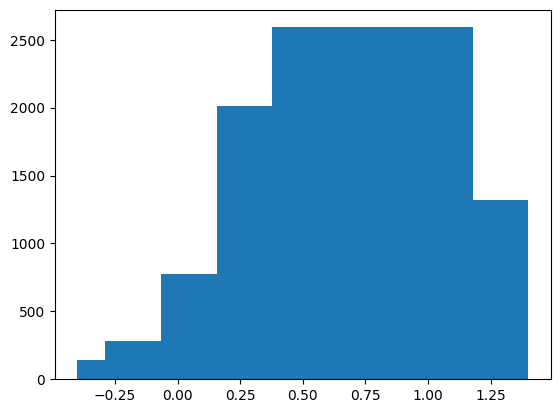

In [38]:
# Plot ratings vs counts histogram to visualise data
rating_counts = ratings['scaled_rating'].value_counts()
print(rating_counts.index)
plt.bar(rating_counts.index, rating_counts.values)

In [39]:
# Merge dataframes to make dataframe containing ratings and genres
full_ratings = pd.merge(ratings, movies, on='movieId')

In [40]:
print("User Preferences Matrix:")
print(full_ratings.head(3), '\n')

User Preferences Matrix:
   userId  movieId  rating   timestamp  scaled_rating  \
0     354    51662     3.5  1200869930       0.666667   
1     307     6957     3.5  1186085807       0.666667   
2      82     5065     3.0  1084465558       0.555556   

                            title                                 genres  
0                      300 (2007)                Action|Fantasy|War|IMAX  
1                Bad Santa (2003)                           Comedy|Crime  
2  Mothman Prophecies, The (2002)  Drama|Fantasy|Horror|Mystery|Thriller   



In [41]:
# OLD CELL BEFORE EXPLODED THE GENRES
# Now group data by userID and genres, assign a mean rating for each (UserID, genre) pair then unpack these into a table
# Unfilled genres are filled with 0 rating

#user_pref = full_ratings.groupby(['userId', 'genres']).rating.mean().unstack(fill_value=0)

In [42]:
# Split the genres and explode the rows
# This is to deal with multiple genre's associated with each movie.
full_ratings['genres'] = full_ratings['genres'].str.split('|')
exploded_ratings = full_ratings.explode('genres')
print(exploded_ratings.head(10), '\n')

   userId  movieId  rating   timestamp  scaled_rating  \
0     354    51662     3.5  1200869930       0.666667   
0     354    51662     3.5  1200869930       0.666667   
0     354    51662     3.5  1200869930       0.666667   
0     354    51662     3.5  1200869930       0.666667   
1     307     6957     3.5  1186085807       0.666667   
1     307     6957     3.5  1186085807       0.666667   
2      82     5065     3.0  1084465558       0.555556   
2      82     5065     3.0  1084465558       0.555556   
2      82     5065     3.0  1084465558       0.555556   
2      82     5065     3.0  1084465558       0.555556   

                            title   genres  
0                      300 (2007)   Action  
0                      300 (2007)  Fantasy  
0                      300 (2007)      War  
0                      300 (2007)     IMAX  
1                Bad Santa (2003)   Comedy  
1                Bad Santa (2003)    Crime  
2  Mothman Prophecies, The (2002)    Drama  
2  Mothman P

In [43]:
# Now group data by userID and genres, assign a mean rating for each (UserID, genre) pair then unpack these into a table
# Unfilled genres are filled with 0 rating
user_pref = exploded_ratings.groupby(['userId', 'genres'])['rating'].mean().unstack(fill_value=0)

In [44]:
# Plot heatmap of correlations between different genres:
user_pref_sample = user_pref.sample(frac=0.5)  # Take 10% of data to reduce computational time
genre_correlation = user_pref_sample.corr() # computes the correlation matrix across columns of user_pref matrix (ie across diff genres)


<Axes: xlabel='genres', ylabel='genres'>

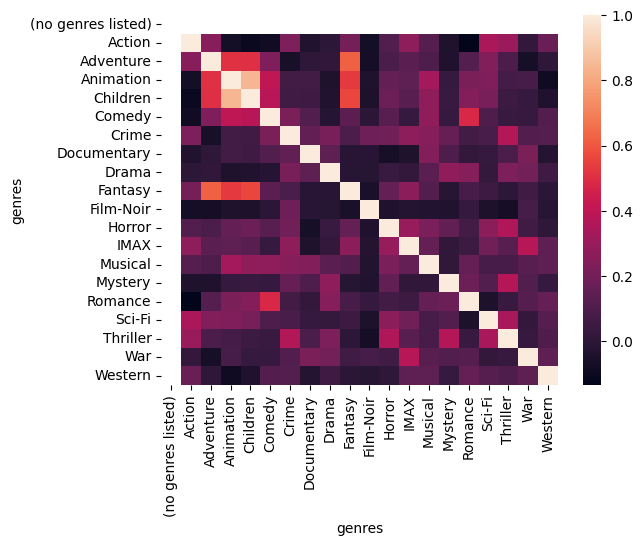

In [45]:
seaborn.heatmap(genre_correlation)

In [46]:
# Now associate a unique integer with every userID and movieID using sklearn's label encoder
from sklearn.preprocessing import LabelEncoder
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()

exploded_ratings['userId'] = user_encoder.fit_transform(exploded_ratings['userId'])
exploded_ratings['movieId'] = movie_encoder.fit_transform(exploded_ratings['movieId'])

In [47]:
# Split the sampled dataframe exploded_ratings into training and testing
from sklearn.model_selection import train_test_split
training_ratings, testing_ratings = train_test_split(exploded_ratings, test_size=0.2, random_state=10)
print(training_ratings['scaled_rating'].max())

1.0


In [48]:
# We now need to define embeddings for each userID and movieID. This represents every user and movie as a vector.
# This is helpful as deals better with unseen userID's and movieID's. Similar users and movies will be close vectors in the embedding space after learning.
# Calc no. unique users
num_users = len(user_encoder.classes_) #user_encoder,classes stores the unique sorted different userID's before lebel encoding
num_movies = len(movie_encoder.classes_)

# Define embedding layers
user_embedding = tf.keras.layers.Embedding(input_dim=num_users, output_dim=50)  # Embedding size = 50 can be tuned. Too high leads to overfitting.
movie_embedding = tf.keras.layers.Embedding(input_dim=num_movies, output_dim=50)


In [49]:
# Input layers
user_input = tf.keras.layers.Input(shape=(1,), name="user_input")
movie_input = tf.keras.layers.Input(shape=(1,), name="movie_input")

# Look up embeddings
user_vec = user_embedding(user_input)
movie_vec = movie_embedding(movie_input)

# Flatten embedding vectors
user_vec = tf.keras.layers.Flatten()(user_vec)
movie_vec = tf.keras.layers.Flatten()(movie_vec)

# Combine embeddings
concat = tf.keras.layers.Concatenate()([user_vec, movie_vec])

# Add dense layers
dense = tf.keras.layers.Dense(128, activation="relu")(concat)
output = tf.keras.layers.Dense(1, activation="sigmoid")(dense)  # Predict rating. Single neuron as predicting a single score for a user/movie pair
# Use sigmoid activation function as ratings are bounded [0,1]

# Build the model
model = tf.keras.models.Model(inputs=[user_input, movie_input], outputs=output)

# Compile the model
model.compile(optimizer="adam", loss="mse", metrics=["mae"])


In [54]:
# Now train the model
# WE use early stopping to keep training until the model no longer improves

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric it monitors - validation loss
    patience=3,          # Number of epochs to wait after improvement halts before stopping
    restore_best_weights=True  # Restores weights from the epoch with the best validation performance
)

# Train with EarlyStopping
model.fit(
    [training_ratings['userId'].values, training_ratings['movieId'].values],  # Input data
    training_ratings['scaled_rating'].values,  # Target ratings
    epochs=100,  # Set a high maximum number of epochs
    batch_size=64, #update weights every 64 training samples
    validation_split=0.2, # Splits out 20&%for validation
    callbacks=[early_stopping]  # Include the callback
)

Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0724 - mae: 0.2268 - val_loss: 0.0533 - val_mae: 0.1901
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0440 - mae: 0.1691 - val_loss: 0.0366 - val_mae: 0.1488
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0263 - mae: 0.1231 - val_loss: 0.0292 - val_mae: 0.1293
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0203 - mae: 0.1059 - val_loss: 0.0250 - val_mae: 0.1140
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0147 - mae: 0.0886 - val_loss: 0.0231 - val_mae: 0.1047
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0127 - mae: 0.0791 - val_loss: 0.0223 - val_mae: 0.1010
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0107 - mae: 0.0718 - val_loss: 0.0221 - val_mae: 0.0984
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0102 - mae: 0.0683 - val_loss: 0.0211 - val_mae: 0.0948
Epoch 9/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.00

In [55]:
X_test = [testing_ratings['userId'].values, testing_ratings['movieId'].values] # Input user and movie IDs
y_test = testing_ratings['scaled_rating'].values # Correct movie ratings

# Evaluate
model.evaluate(X_test, y_test) # Run the model on the test data. Then compare to the actual rankings

# Predict for new user-movie pairs
predictions = model.predict(X_test) # Array containing the predictions


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0200 - mae: 0.0650
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


<ipython-input-56-8ca494b454c3>:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


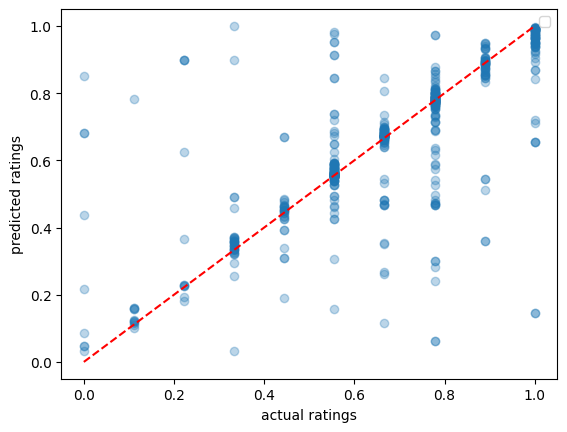

In [56]:
# Now visualise on scatter plot

plt.scatter(y_test, predictions, alpha = 0.3)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('actual ratings')
plt.ylabel('predicted ratings')
plt.legend()

In [ ]:
# Now assume uniform prior for genres, use Dirichilet distribution as total prob sums to 1
with pm.Model() as model:
    user_genre_pref = pm.Dirichlet('user_genre_pref', a=np.ones(user_pref.shape[1]))